Osnabrück University - Computer Vision (Winter Term 2016/17) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 08: Template Matching and Pattern Recognition

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, January 22, 2017**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Covariance) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What does *covariance* express?

**b)** Provide a formula to compute the covariance of two 1-dimensional datasets. How can it be generalized to the $n$-dimensional case?

**c)** Create and plot two (1-dimensional) datasets with high covariance. Then do the same for two two datasets with low covariance.

## Exercise 1 (Template Matching – 8p)

**a)** Explain in your own words the idea of *template matching*. Is it a data or model based approach? What are the advantages and disadvantages? In what situations would you apply template matching?

Template matching is model-bases since one goes into it with a preconception of what to find, more or less excatly. This is a top-down process. 

**b)** Explain the ideas of *mean absolute difference* and *correlation coefficient*? Name pros and cons.

# Mean absolute difference
MAD is simply the average of difference between the pixels of a template image anchored at some location and the underlying pixels of the data.

# Correlation coefficient
The correlation covariance divided by product of stds) coefficient measures how consistently a template pixel's deviation from the template mean coincides with an image pixel's deviation from the image mean, summed over all overlapping pixels. A coefficient of {1,-1} means template and images are related by a linear transform and otherwise match perfectly. A coefficient of 0 means they don't correlate.

# Evaluation
## MAD
| Pro | Con |
|---|---|
| Easy to compute  |  Sensitive to rotation |
| Noise robust  | Depends on gray value scaling + abs value  |

## MAD
| Pro | Con |
|---|---|
| Easy to compute by convolution  |  Sensitive to rotation |
| Noise robust  | Sensistive to different gray value ratios across regions between template and image  |
| Insensitive to gray value scaling + abs value| |

**c)** Where is Waldo? In the two images `wheresWaldo1.jpg` and `wheresWaldo2.jpg`, Waldo is hiding in the midst of
a busy crowd. He always wears the same red and white striped sweater and hat. However, he
may be carrying a something that varies from scene to scene.
Use template matching with the given Waldo templates (`Waldo.zip`) to locate Waldo. Highlight
Waldo in the scene and indicate which template was matched.

As you can see, the approach from the lecture doesn't seem to work at all.  The "correlation" does not even have valid values. Maybe the empty space around the template causes issues. Since I've wasted hours on this, I shall simply stop it now.

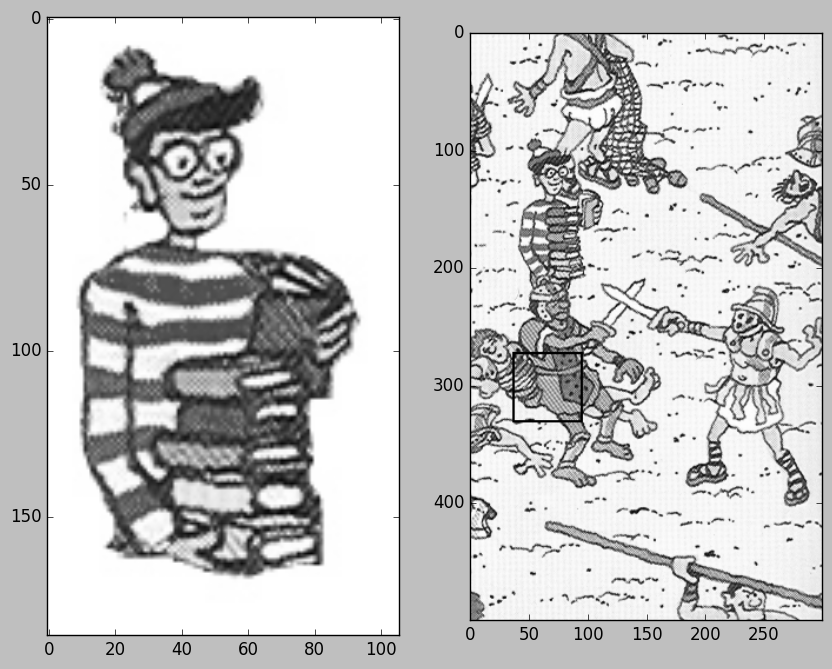

In [7]:
import matplotlib
from scipy.misc import imread
from scipy.signal import convolve, fftconvolve
from numpy.fft import fft2, ifft2
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

def draw_box(img, center, halfwidth=30, val=0):
    """Draw a box around center"""
    m,n = img.shape
    mx, my = center
    l = halfwidth
    img[max(0,mx-l):min(m,mx-l+2),max(0,my-l):min(n,my+l)] = val
    img[max(0,mx-l):min(m,mx+l),max(0,my-l):min(n,my-l+2)] = val
    img[max(0,mx+l-2):min(m,mx+l),max(0,my-l):min(n,my+l)] = val
    img[max(0,mx-l):min(m,mx+l),max(0,my+l-2):min(n,my+l)] = val

# load image
img1 = imread('waldo/wheresWaldo1.jpg', mode='L')[600:1100,1400:1700]

# zero-mean templates
templates = [imread('waldo/waldo{}.jpg'.format(d), mode='L') for d in range(1,2)]
templates = [t - t.mean() for t in templates]

# array for correlation coefficients
X, Y = img1.shape
corr_coeffs = np.zeros((X, Y, len(templates)))

# do fourier convolution
conv = fftconvolve(img1, templates[0], mode='same')
# the range of values is not [-1,1] ?????
corr_coeffs[:,:,0] = conv / (img1.std() * templates[0].std())

max_loc = np.unravel_index(np.argmax(corr_coeffs[:,:,0]), img1.shape)


draw_box(img1, max_loc, 30)

plt.subplot(1,2,1)
plt.imshow(templates[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img1, cmap='gray')
plt.show()


## Exercise 2 (Pattern Recognition – 6p)

**a)** What are the goals of *pattern recognition*? How can they be achieved? What are the problems?

The goal is to recognise patterns. That is the ability to identify objects from an image.

**b)** What is *principal component analysis*? How is it related to pattern recognition?

Principal components of a multidimensional dataset are the directions in the vector space along which the data exhibits the maximal variance. Reducing the data onto this dimensionality (via projection) thus captures the most information while reducing the overall dimensionality. 

This can be used for pattern recognition by building a database of known patterns/classes projected onto the principal components and clustering those. For classifying a new datapoint, it is projected on the principal components too and compared to the database. The closest matching cluster is identified as the object category.

**c)** Explain how principal components can be computed? Then implement a function that performs the computation.

Principal components are the eigenvectors of the data's autocorrelation matrix, which is the averaged sum of outer products of data vectors.

In [ ]:
import numpy as np

def pca(data):
    """
    Perform principal component analysis.
    
    Arguments:
        data - an k*n dimensional array (k entries with n dimensions)
        
    Results:
        pc - an array holding the principal components
    """
    # apparently, the dot product of a (20, 32256) array consumes > 9G of memory
    # oO for unfathomable reasons. Numpy just seems to copy it around thousands
    # of times. Hence, this exercise is computationally unsolvable for me
    # Even with fixing the dtype of the loaded images to 1 byte (which would
    # have the product occupy only ~1G), numpy multiplies everything and still
    # brings the system to a halt


    # seems hard to believe, but this is actually sum(np.outer(row,row) for row in data)
    autocorr = data.T.dot(data)
    autocorr = autocorr / autocorr.mean()
    evals, evecs = np.linalg.eig(autocorr)
    
    return evecs


## Exercise 3 (Eigenfaces – 6p)

**a)** Import the images in `trainimgs.zip` into an numpy array using the function `read_images_from_directory` provided in the cell below. Then use PCA to compute the eigenfaces (i.e. the eigenvectors of the face images). You may use your PCA function from Exercise 2 or some build in function. Explain what kind of input PCA expects, and how that fits to our images (you may have to `reshape` the images!).
Finally, display the eigenfaces.

In [ ]:
import sys
import os
import glob
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt


def read_images_from_directory(directory,suffix,shape):
    """
    Read all images found in DIRECTORY with given file
    name SUFFIX. All images should have the same SHAPE,
    specified as (rows,columns).
    
    Returns:
        images: A numpy array of shape m*rows*columns (from shape)
        names: A list of corresponding image names.
    """
    
    # initialize the image array and name list
    images = np.empty((0, *shape)) # <- Should be uint8
    names = []

    # now loop through all image files in the directory
    for file_name in glob.glob(directory + '/*.' + suffix):
        if os.path.isfile(file_name):

            # load each image (as double)
            img = misc.imread(file_name, mode = 'F') # <-- WHY NOT L
            
            # check for correct size
            if img.shape == shape:
                images = np.append(images,img.reshape((1,*shape)),axis=0)
                names.append(os.path.basename(file_name))
            else:
                print('warning: Image "' + file_name + '" with wrong size will be ignored!', file=sys.stderr)
        
    return images, names


img_shape = (192 ,168);
train_imgs, train_names = read_images_from_directory('trainimg', 'pgm', img_shape)
m, n, k = train_imgs.shape
train_imgs_flat = np.reshape(train_imgs, (m, n * k))

# run this, I dare you
evecs = pca(train_imgs_flat)


**b)** Now project the training face images into the eigenspace to calculate their ”feature vectors”,
i.e. a representation with significantly lower dimension. For the projection of the face images,
they have to be centered first, i.e. the mean face vector has to be subtracted. Store the representation achieved in this way in some array (`face_db`). Then implement the function `recognize_face` that recognizes a face from that database by calculate the euclidean distance of this face feature vector to all of the training feature vectors from the database. The feature vector with the
smallest distance represents the winner category. Display the input image and the winner
image (image corresponding to the winner feature vector) beside each other to check the
correctness of your implementation.


In [ ]:
def recognize_face(face, eigenfaces, mean_face, face_db)
    """
    Recognize a face from a face database.
    and return the index of the best matching database entry.

    The FACE is first centered and projected into the eigeface
    space provided by EIGENFACES. Then the best match is found
    according to the euclidean distance in the eigenface space.
    """
    index = -1
    
    # FIXME: put your code here!

    return index




**c)** Now classify the images in `testimg.zip`. Try to reduce the number of principal components
used. How many PCs are necessary to still achieve perfect classification?

In [ ]:
# FIXME: put your code here!
